In [1]:
#setup - rememeber to switch to tensorflow 2.3 kernel...
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import scipy.io as sio
import datetime
import trimesh
import time
from vedo import *
from ipyvtklink.viewer import ViewInteractiveWidget

#need to have these two lines to work on my ancient 1060 3gb
#  https://stackoverflow.com/questions/43990046/tensorflow-blas-gemm-launch-failed
physical_devices = tf.config.list_physical_devices('GPU') 
tf.config.experimental.set_memory_growth(physical_devices[0], True)

print(tf.__version__)

# %matplotlib inline
# plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
# plt.rcParams['image.interpolation'] = 'nearest'
# plt.rcParams['image.cmap'] = 'gray'
%matplotlib notebook

%load_ext tensorboard

# for auto-reloading external modules
%load_ext autoreload
%autoreload 2
%autosave 180

C:\Users\Derm\anaconda3\envs\tf23\lib\site-packages\numpy\_distributor_init.py:32: UserWarning: loaded more than 1 DLL from .libs:
C:\Users\Derm\anaconda3\envs\tf23\lib\site-packages\numpy\.libs\libopenblas.PYQHXLVVQ7VESDPUVUADXEVJOBGHJPAY.gfortran-win_amd64.dll
C:\Users\Derm\anaconda3\envs\tf23\lib\site-packages\numpy\.libs\libopenblas.XWYDX2IKJW2NMTWSFYNGFUWKQU3LYTCZ.gfortran-win_amd64.dll
  stacklevel=1)


2.3.0


Autosaving every 180 seconds


In [ ]:
#load OFF file from ModelNet10 dir
start = time.time()
fn = 'C:/Users/Derm/Desktop/big/ModelNet10/toilet/train/toilet_0069.off'
# fn = 'C:/Users/Derm/Desktop/big/ModelNet10/sofa/train/sofa_0370.off'
# fn = 'C:/Users/Derm/Desktop/big/ModelNet10/bed/train/bed_0320.off'


M = trimesh.load(fn)
test = trimesh.sample.sample_surface(M, 100)
print("took ", time.time() - start, "seconds")

In [ ]:
#use Vedo to plot OG and subsampled surfaces
plt1 = Plotter(N = 1, axes = 4, bg = (1, 1, 1), interactive = True)
disp = []

# disp.append(Points(M.vertices, c = 'blue', r = 4))
disp.append(Points(test[0], c = 'red', r = 5))
toilet = Mesh(M).c("gray").alpha(0.2)
disp.append(toilet)

plt1.show(disp, "surface sampling test")
ViewInteractiveWidget(plt1.window)

In [2]:
#define rotation matrix used to transform point clouds
def R_tf(angs):
    if len(tf.shape(angs)) == 1:
        angs = angs[None,:]
    phi = angs[:,0]
    theta = angs[:,1]
    psi = angs[:,2]
    mat = tf.Variable([[cos(theta)*cos(psi), sin(psi)*cos(phi) + sin(phi)*sin(theta)*cos(psi), sin(phi)*sin(psi) - sin(theta)*cos(phi)*cos(psi)],
                       [-sin(psi)*cos(theta), cos(phi)*cos(psi) - sin(phi)*sin(theta)*sin(psi), sin(phi)*cos(psi) + sin(theta)*sin(psi)*cos(phi)],
                       [sin(theta), -sin(phi)*cos(theta), cos(phi)*cos(theta)]
                        ])
    mat = tf.transpose(mat, [2, 0, 1])
    mat = tf.squeeze(mat)
    return mat

# determine euler angles from rotation matrix
def R2Euler(mat):
    if len( tf.shape(mat) ) == 2:
        mat = mat[None, :, :]
    R_sum = np.sqrt(( mat[:,0,0]**2 + mat[:,0,1]**2 + mat[:,1,2]**2 + mat[:,2,2]**2 ) / 2)
    phi = np.arctan2(-mat[:,1,2],mat[:,2,2])
    theta = np.arctan2(mat[:,0,2], R_sum)
    psi = np.arctan2(-mat[:,0,1], mat[:,0,0])
    angs = np.array([phi, theta, psi])
    return angs

In [ ]:
#generate toy dataset using all of the toilets in the ModelNet10 repository
numMeshes = 300 #344
ptsPerCloud = 256 #was 25 in OG method 
iterPerMesh = 200 #100  #number of times to sample clouds from each mesh

#init vector to store sampled point clouds
x = np.zeros([numMeshes*iterPerMesh, ptsPerCloud*2, 3])
#init vector to store transformations 
y = np.zeros([numMeshes*iterPerMesh, 6]) #rotation and translation
# y = np.zeros([numMeshes*iterPerMesh, 3]) #if only considering translations

#scale trans and rotation params so outputs are equally weighted
trans_scale = 10.0 #2.0
rot_scale = 0.2 #0.2

for i in range(numMeshes):
    if i % 10 == 0:
        print(i)
    fn = 'C:/Users/Derm/Desktop/big/ModelNet10/toilet/train/toilet_%04d.off' %(i+1) #loop through file names
#     fn = 'C:/Users/Derm/Desktop/big/ModelNet10/bed/train/bed_0059.off'
#     fn = 'C:/Users/Derm/Desktop/big/ModelNet10/toilet/train/toilet_0069.off' #debug -> only use single toilet model
    M = trimesh.load(fn)

    #more efficient to sample all points at once and then just use some for each frame
    sam1 = trimesh.sample.sample_surface(M, iterPerMesh*ptsPerCloud)[0] #get keyframe scan
    sam2 = trimesh.sample.sample_surface(M, iterPerMesh*ptsPerCloud)[0] #get new scan
#     sam2 = sam1 + 0.01*np.random.randn(np.shape(sam1)[0], 3) #copy point locations and add some noise
    
    for j in range(iterPerMesh):
        #rotate keyframe
        angs1 = 0.5*tf.random.normal([3])
        rot1 = R_tf(angs1)
        #rotate scan 2 relative to keyframe
        angs2 = rot_scale*tf.random.normal([3])
#         rot2 = R_tf(angs1 + angs2) #was this (wrong??)
#         angs2 = tf.zeros([3]) # ~~~~~~~~~~~~~~~ zero out rotation (for debug) ~~~~~~~~~~~~~~~~~~~~~~
#         rot2 = tf.matmul(R_tf(angs1), R_tf(angs2)) #was this (wrong??)
        rot2 = tf.matmul(R_tf(angs2), R_tf(angs1)) #test

        
        # randomly grow/shrink each point cloud before translation
        scale = 1. + 0.2*tf.random.normal([1])[0]

        x[i*iterPerMesh + j, :ptsPerCloud, :] = sam1[j*ptsPerCloud:(j+1)*ptsPerCloud].dot(rot1.numpy())*scale           
            
        trans = trans_scale*tf.random.normal([3])
        #was this (incorrect for large angle deviation?)
#         sam2_j = trans + sam2[j*ptsPerCloud:(j+1)*ptsPerCloud].dot(rot1.numpy()).dot(rot2.numpy())*scale 
        sam2_j = trans + sam2[j*ptsPerCloud:(j+1)*ptsPerCloud].dot(rot2.numpy())*scale 
        x[i*iterPerMesh + j, ptsPerCloud:, :] = sam2_j

        #save transformation as y
        y[i*iterPerMesh + j,:3] = trans.numpy()/trans_scale
        y[i*iterPerMesh + j,3:] = angs2.numpy()/rot_scale

In [ ]:
#split into train and test sets, save to file
split = 0.9
x_train = x[:int(split*np.shape(x)[0])]
# np.save('C:/Users/Derm/Desktop/big/ModelNet10/toilet/train/x_train', x_train)
x_test = x[int(split*np.shape(x)[0]):]
# np.save('C:/Users/Derm/Desktop/big/ModelNet10/toilet/train/x_test', x_test)
y_train = y[:int(split*np.shape(y)[0])]
# np.save('C:/Users/Derm/Desktop/big/ModelNet10/toilet/train/y_train', y_train)
y_test = y[int(split*np.shape(y)[0]):]
# np.save('C:/Users/Derm/Desktop/big/ModelNet10/toilet/train/y_test', y_test)

In [3]:
#load data from memory
numMeshes = 300 #344
ptsPerCloud = 256 #was 25 in OG method 
iterPerMesh = 200 #100  #number of times to sample clouds from each mesh
trans_scale = 10.0 #2.0
rot_scale = 0.2 #0.2

# x_train = np.load('C:/Users/Derm/Desktop/big/ModelNet10/toilet/train/x_train.npy')
# y_train = np.load('C:/Users/Derm/Desktop/big/ModelNet10/toilet/train/y_train.npy')
# x_test = np.load('C:/Users/Derm/Desktop/big/ModelNet10/toilet/train/x_test.npy')
# y_test = np.load('C:/Users/Derm/Desktop/big/ModelNet10/toilet/train/y_test.npy')

x_train = np.load('C:/Users/Derm/Desktop/big/ModelNet10/toilet/train/x_train_trans_only.npy')
y_train = np.load('C:/Users/Derm/Desktop/big/ModelNet10/toilet/train/y_train_trans_only.npy')
x_test = np.load('C:/Users/Derm/Desktop/big/ModelNet10/toilet/train/x_test_trans_only.npy')
y_test = np.load('C:/Users/Derm/Desktop/big/ModelNet10/toilet/train/y_test_trans_only.npy')

In [4]:
x_train = tf.convert_to_tensor(x_train)
y_train = tf.convert_to_tensor(y_train)
x_test = tf.convert_to_tensor(x_test)
y_test = tf.convert_to_tensor(y_test)
print(tf.shape(x_train))
print(tf.shape(y_train))

# print(y_train[1])

tf.Tensor([54000   512     3], shape=(3,), dtype=int32)
tf.Tensor([54000     6], shape=(2,), dtype=int32)


In [5]:
#train network
from network import Net #mine
# from pcrnet import Network as Net #PCR-Net baseline
np.random.seed(1337)
runLen =  300 #30

def scheduler(epoch, learning_rate):
    part1 = runLen//3
    part2 = 2*runLen//3 #net2
    if epoch < part1:
        learning_rate = 0.01
        return learning_rate
    if epoch >= part1 and epoch < part2:
        learning_rate = 0.005 #0.001
        return learning_rate
    if epoch >= part2:
        learning_rate = 0.00025 #0.00025
        return learning_rate

model = Net()
model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate = 0.001),
              loss = tf.keras.losses.MeanAbsoluteError()) #was MeanAbsoluteError()

summary = model.summary()
print(summary)
scheduler = tf.keras.callbacks.LearningRateScheduler(scheduler)
cp = tf.keras.callbacks.ModelCheckpoint("DermNet_ModelNet_benchmark_cp.kmod", monitor = 'val_loss', save_best_only = True) 

log_dir = "runs/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

trace = model.fit(x = x_train, y = y_train, batch_size = 512, epochs=runLen, verbose=1, 
                  validation_split = 0.1, shuffle=True, callbacks = [cp])

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 512, 3)]          0         
_________________________________________________________________
tf_op_layer_ExpandDims (Tens [(None, 512, 3, 1)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 512, 1, 64)        256       
_________________________________________________________________
batch_normalization (BatchNo (None, 512, 1, 64)        256       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 512, 1, 64)        4160      
_________________________________________________________________
batch_normalization_1 (Batch (None, 512, 1, 64)        256       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 512, 1, 256)      

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: unsupported operand type(s) for -: 'NoneType' and 'int'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
INFO:tensorflow:Assets written to: DermNet_ModelNet_benchmark_cp.kmod\assets
95/95 [==============================] - 36s 381ms/step - loss: 0.1528 - val_loss: 0.8988
Epoch 3/300
95/95 [==============================] - ETA: 0s - loss: 0.1235WARNING:tensorflow:AutoGraph could not transform <function canonicalize_signatures.<locals>.signature_wrapper at 0x000001F29A2175E8> and will run it as-is.
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: unsupported operand type(s) for -: 'NoneType' and 'int'
To silence this warning, decorate the function with @tf.autogr

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: unsupported operand type(s) for -: 'NoneType' and 'int'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
INFO:tensorflow:Assets written to: DermNet_ModelNet_benchmark_cp.kmod\assets
95/95 [==============================] - 36s 375ms/step - loss: 0.0826 - val_loss: 0.1082
Epoch 10/300
95/95 [==============================] - ETA: 0s - loss: 0.0829WARNING:tensorflow:AutoGraph could not transform <function canonicalize_signatures.<locals>.signature_wrapper at 0x000001F29AB90798> and will run it as-is.
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: unsupported operand type(s) for -: 'NoneType' and 'int'
To silence this warning, decorate the function with @tf.autog

95/95 [==============================] - 35s 374ms/step - loss: 0.0652 - val_loss: 0.0562
Epoch 22/300
95/95 [==============================] - 33s 346ms/step - loss: 0.0651 - val_loss: 0.0608
Epoch 23/300
95/95 [==============================] - ETA: 0s - loss: 0.0642WARNING:tensorflow:AutoGraph could not transform <function canonicalize_signatures.<locals>.signature_wrapper at 0x000001F2986105E8> and will run it as-is.
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: unsupported operand type(s) for -: 'NoneType' and 'int'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: unsupported operand type(s) for -: 'NoneType' and 'int'
To silence this warning, decorate t

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: unsupported operand type(s) for -: 'NoneType' and 'int'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
INFO:tensorflow:Assets written to: DermNet_ModelNet_benchmark_cp.kmod\assets
95/95 [==============================] - 36s 374ms/step - loss: 0.0576 - val_loss: 0.0432
Epoch 38/300
95/95 [==============================] - 33s 348ms/step - loss: 0.0585 - val_loss: 0.0515
Epoch 39/300
95/95 [==============================] - 33s 347ms/step - loss: 0.0572 - val_loss: 0.0547
Epoch 40/300
95/95 [==============================] - 33s 347ms/step - loss: 0.0564 - val_loss: 0.0505
Epoch 41/300
95/95 [==============================] - 33s 346ms/step - loss: 0.0560 - val_loss: 0.0524
Epoch 42/300
95/95 [==============================] - 33s 348ms/step - loss: 0.0564 - val_loss: 0.0457
E

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: unsupported operand type(s) for -: 'NoneType' and 'int'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
INFO:tensorflow:Assets written to: DermNet_ModelNet_benchmark_cp.kmod\assets
95/95 [==============================] - 36s 375ms/step - loss: 0.0528 - val_loss: 0.0364
Epoch 78/300
95/95 [==============================] - 33s 344ms/step - loss: 0.0507 - val_loss: 0.0406
Epoch 79/300
95/95 [==============================] - 33s 344ms/step - loss: 0.0515 - val_loss: 0.0379
Epoch 80/300
95/95 [==============================] - 33s 344ms/step - loss: 0.0523 - val_loss: 0.0601
Epoch 81/300
95/95 [==============================] - 33s 344ms/step - loss: 0.0511 - val_loss: 0.0471
Epoch 82/300
95/95 [==============================] - 33s 345ms/step - loss: 0.0501 - val_loss: 0.0417
E

95/95 [==============================] - 33s 344ms/step - loss: 0.0478 - val_loss: 0.0345
Epoch 131/300
95/95 [==============================] - 33s 346ms/step - loss: 0.0469 - val_loss: 0.0429
Epoch 132/300
95/95 [==============================] - 33s 344ms/step - loss: 0.0473 - val_loss: 0.0373
Epoch 133/300
95/95 [==============================] - 33s 344ms/step - loss: 0.0484 - val_loss: 0.0414
Epoch 134/300
95/95 [==============================] - 33s 345ms/step - loss: 0.0476 - val_loss: 0.0502
Epoch 135/300
95/95 [==============================] - 33s 345ms/step - loss: 0.0477 - val_loss: 0.0446
Epoch 136/300
95/95 [==============================] - 33s 346ms/step - loss: 0.0469 - val_loss: 0.0379
Epoch 137/300
95/95 [==============================] - 33s 344ms/step - loss: 0.0475 - val_loss: 0.0351
Epoch 138/300
95/95 [==============================] - 33s 345ms/step - loss: 0.0466 - val_loss: 0.0453
Epoch 139/300
95/95 [==============================] - 33s 345ms/step - loss: 

95/95 [==============================] - 33s 352ms/step - loss: 0.0439 - val_loss: 0.0431
Epoch 199/300
95/95 [==============================] - 33s 344ms/step - loss: 0.0478 - val_loss: 0.1418
Epoch 200/300
95/95 [==============================] - 33s 344ms/step - loss: 0.0512 - val_loss: 0.0758
Epoch 201/300
95/95 [==============================] - 33s 344ms/step - loss: 0.0455 - val_loss: 0.0503
Epoch 202/300
95/95 [==============================] - 33s 345ms/step - loss: 0.0461 - val_loss: 0.0499
Epoch 203/300
95/95 [==============================] - 33s 345ms/step - loss: 0.0461 - val_loss: 0.0372
Epoch 204/300
95/95 [==============================] - 33s 344ms/step - loss: 0.0444 - val_loss: 0.0470
Epoch 205/300
95/95 [==============================] - 33s 344ms/step - loss: 0.0440 - val_loss: 0.0362
Epoch 206/300
95/95 [==============================] - 33s 345ms/step - loss: 0.0440 - val_loss: 0.0374
Epoch 207/300
95/95 [==============================] - 33s 345ms/step - loss: 

Epoch 277/300
95/95 [==============================] - 33s 345ms/step - loss: 0.0408 - val_loss: 0.0427
Epoch 278/300
95/95 [==============================] - 33s 345ms/step - loss: 0.0415 - val_loss: 0.0351
Epoch 279/300
95/95 [==============================] - 33s 345ms/step - loss: 0.0410 - val_loss: 0.0433
Epoch 280/300
95/95 [==============================] - 33s 344ms/step - loss: 0.0480 - val_loss: 0.0546
Epoch 281/300
95/95 [==============================] - 33s 345ms/step - loss: 0.0454 - val_loss: 0.0431
Epoch 282/300
95/95 [==============================] - 33s 345ms/step - loss: 0.0437 - val_loss: 0.0620
Epoch 283/300
95/95 [==============================] - 33s 344ms/step - loss: 0.0436 - val_loss: 0.0346
Epoch 284/300
95/95 [==============================] - 33s 346ms/step - loss: 0.0427 - val_loss: 0.0412
Epoch 285/300
95/95 [==============================] - 33s 344ms/step - loss: 0.0419 - val_loss: 0.0454
Epoch 286/300
95/95 [==============================] - 33s 345ms

<IPython.core.display.Javascript object>


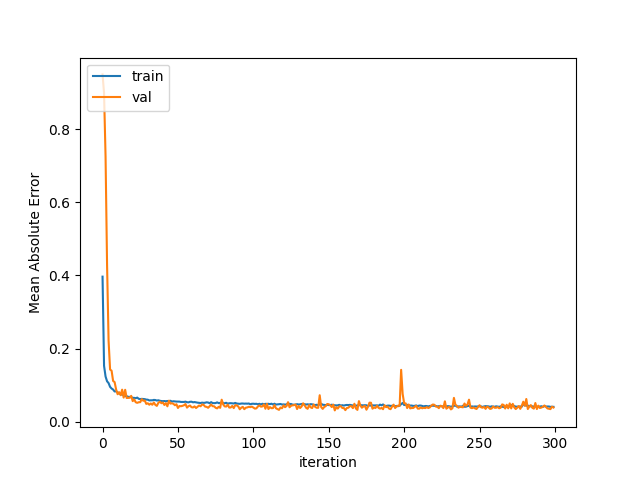

Text(0, 0.5, 'Mean Absolute Error')

In [6]:
# Network Loss Plots
from matplotlib import pyplot as plt
fig0, ax0 = plt.subplots()
ax0.plot(trace.history['loss'], '-')
ax0.plot(trace.history['val_loss'], '-')
ax0.legend(['train', 'val'], loc='upper left')
ax0.set_xlabel('iteration')
ax0.set_ylabel('Mean Absolute Error')

In [27]:
#temp- get center location of each point cloud to make sure net isn't just matching centroids
idx = int(np.floor(100*np.random.randn()))
mu1 = tf.math.reduce_mean(x_train[idx, :ptsPerCloud, :], axis = 0)
mu2 = tf.math.reduce_mean(x_train[idx, ptsPerCloud:, :], axis = 0) - (y_train[idx,:3]*trans_scale)
print(mu1)
print(mu2)
center_error = mu1 - mu2
print(center_error)

tf.Tensor([1.82179523 3.2741554  1.68902776], shape=(3,), dtype=float64)
tf.Tensor([3.14381527 3.5712673  3.54666586], shape=(3,), dtype=float64)
tf.Tensor([-1.32202004 -0.29711189 -1.8576381 ], shape=(3,), dtype=float64)


In [8]:
#look at errors at never-before-seen test data generated from similar objects in ModelNet10
guess = model.predict(x_train[:4])
error = y_train[:4] - guess
# print(guess)
# print(y_train[:4])
# print(error)

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: unsupported operand type(s) for -: 'NoneType' and 'int'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: unsupported operand type(s) for -: 'NoneType' and 'int'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


In [25]:
#Generate special test data for this visualization (evenly sampled)
#  (doing this so we can draw the underlying model from which points were sampled)
fn = 'C:/Users/Derm/Desktop/big/ModelNet10/toilet/train/toilet_0310.off' #0310 looks best
# fn = 'C:/Users/Derm/Desktop/big/ModelNet10/bed/train/bed_0199.off' 

M = trimesh.load(fn)

n_tests = 1 #number of test samples to generate
#init vector to store sampled point clouds
x_test2 = np.zeros([n_tests, ptsPerCloud*2, 3])
#init vector to store transformations 
y_test2 = np.zeros([n_tests, 6]) #rotation and translation

sam1 = trimesh.sample.sample_surface(M, n_tests*ptsPerCloud)[0] #get keyframe scan
sam2 = trimesh.sample.sample_surface(M, n_tests*ptsPerCloud)[0] #get new scan

for j in range(n_tests):
    angs1 = 0.5*tf.random.normal([3])    #rotate keyframe
    rot1 = R_tf(angs1)
    angs2 = rot_scale*tf.random.normal([3])     #rotate scan 2 relative to keyframe
    angs2 = tf.zeros([3]) # ~~~~~~~~~~~~~~~ zero out rotation (for debug) ~~~~~~~~~~~~~~~~~~~~~~
    rot2 = R_tf(angs2)
    #     rot_combined = R_tf(angs1 + angs2) #was this
    rot_combined = tf.matmul(R_tf(angs1), R_tf(angs2))
    
    x_test2[j, :ptsPerCloud, :] = sam1[j*ptsPerCloud:(j+1)*ptsPerCloud].dot(rot1.numpy())         

    trans = trans_scale*tf.random.normal([3])
    #was this
    sam2_j = trans + sam2[j*ptsPerCloud:(j+1)*ptsPerCloud].dot(rot_combined.numpy()) #transform scan
    #DEBUG
#     sam2_j = (sam2[j*ptsPerCloud:(j+1)*ptsPerCloud]+trans.numpy()).dot(rot_combined.numpy()) #transform scan
    x_test2[j, ptsPerCloud:, :] = sam2_j

    #save transformation as y
    y_test2[j,:3] = trans.numpy()/trans_scale
    y_test2[j,3:] = angs2.numpy()/rot_scale
print(tf.shape(x_test2))

tf.Tensor([  1 512   3], shape=(3,), dtype=int32)


In [26]:
#visualize network performance on evenly sampled data
t = 0 #test number to draw
niter = 5 #number of iterations to run network for

plt2 = Plotter(N = 3, axes = 4, bg = (1, 1, 1), interactive = True)
disp1 = [] #before estimated transformation (drawn on left)
disp2 = [] #after 1 transformation (drawn in center)
disp3 = [] #after niter transformations

#draw first viz (untransformed set of scans)-------------------
scan1 = Mesh(M).c("red").alpha(0.1)#.rotate(90, axis = (0,0,1))
scan1.applyTransform(rot1.numpy().T)
disp1.append(scan1)
disp1.append(Points(x_test2[0,:ptsPerCloud], c = 'red', r = 5))

scan2 = Mesh(M).c("blue").alpha(0.1)
scan2.applyTransform(rot_combined.numpy().T)
# scan2.pos(y_test2[t,0], y_test2[t,1], y_test2[t,2])
scan2.pos(y_test2[t,0]*trans_scale, y_test2[t,1]*trans_scale, y_test2[t,2]*trans_scale)
disp1.append(scan2)
disp1.append(Points(x_test2[0,ptsPerCloud:], c = 'blue', r = 5))

#FOR DEBUG - draw ground truth transformation in green so I can be sure which order is correct
# correct = (x_test2[0,ptsPerCloud:] - y_test2[0,:3]*trans_scale).dot(R_tf(y_test2[0,3:]*rot_scale).numpy().T)
# temp = Points(correct, c = 'green', r = 5)
# disp1.append(temp)
#---------------------------------------------------------------

#draw esatimated soln after 1 iteration ------------------------
ans_cum = model.predict(x_test2)[t]
ans_cum[:3] = ans_cum[:3]*trans_scale
ans_cum[3:] = ans_cum[3:]*rot_scale

#draw meshes
soln_est_rot = R_tf(ans_cum[3:])
scan2_transformed = Mesh(M).c("blue").alpha(0.1)
scan2_transformed.applyTransform(soln_est_rot.numpy().dot(rot_combined.numpy().T))
scan2_transformed.pos(y_test2[t,0]*trans_scale - ans_cum[0], 
                      y_test2[t,1]*trans_scale - ans_cum[1], 
                      y_test2[t,2]*trans_scale - ans_cum[2])
disp2.append(scan2_transformed)
disp2.append(Mesh(M).c("red").alpha(0.1).applyTransform(rot1.numpy().T)) #draw keyframe

#add points
scan2_pts_transformed = (x_test2[0,ptsPerCloud:] - ans_cum[:3]).dot(soln_est_rot.numpy().T)
# scan2_pts_transformed = (x_test2[0,ptsPerCloud:]).dot(soln_est_rot.numpy().T) - ans_cum[:3]
disp2.append(Points(scan2_pts_transformed, c = 'blue', r = 5))

disp2.append(Points(x_test2[0,:ptsPerCloud], c = 'red', r = 5))
gt = y_test2[t].copy()
gt[:3] = gt[:3]*trans_scale
gt[3:] = gt[3:]*rot_scale
print("\n ground truth:", gt)
print("\n estimate from DNN after 1 iteration:", ans_cum)
#-----------------------------------------------------------------

# draw estiamted soln after n interations-------------------------
#TODO: need to figure out more compat way of representing sequential 6DOF transforms
for i in range(niter):
    #replace initial scan2 with transformed pc2 as input to network
    inlayer = tf.concat([x_test2[0][:ptsPerCloud], scan2_pts_transformed], axis = 0)[None, :, :]
    ans_i = model.predict(inlayer)[0]
    ans_i[:3] = ans_i[:3]*trans_scale
    ans_i[3:] = ans_i[3:]*rot_scale
    
#     soln_est_rot = tf.matmul(R_tf(ans_i[3:]), soln_est_rot)
    soln_est_rot = R_tf(ans_i[3:]) #test
    ans_cum[:3] = ans_cum[:3] + ans_i[:3]
#     ans_cum[3:] = R2Euler(soln_est_rot)[:,0]
    ans_cum[3:] = R2Euler(tf.matmul(R_tf(ans_i[3:]), soln_est_rot))[:,0]
    scan2_pts_transformed = (x_test2[0,ptsPerCloud:] - ans_cum[:3]).dot(soln_est_rot.numpy().T)
    
# print("\n estimate from DNN after", niter, "iterations: ", ans_cum) 

scan2_transformed_again = Mesh(M).c("blue").alpha(0.1)
scan2_transformed_again.applyTransform(soln_est_rot.numpy().dot(rot_combined.numpy().T)) #test
scan2_transformed_again.pos(y_test2[t,0]*trans_scale - ans_cum[0], 
                            y_test2[t,1]*trans_scale - ans_cum[1], 
                            y_test2[t,2]*trans_scale - ans_cum[2])
disp3.append(scan2_transformed_again)
disp3.append(Points(scan2_pts_transformed, c = 'blue', r = 5))
disp3.append(Points(x_test2[0,:ptsPerCloud], c = 'red', r = 5))
disp3.append(Mesh(M).c("red").alpha(0.1).applyTransform(rot1.numpy().T)) #keyframe

print("------- \n Final Error:", gt - ans_cum)
# #---------------------------------------------------------------

    
plt2.show(disp1, "initial transformation", at = 0)
plt2.show(disp2, "after 1 iteration", at = 1)
plt2.show(disp3, "after 5 iterations", at = 2)
ViewInteractiveWidget(plt2.window)

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: unsupported operand type(s) for -: 'NoneType' and 'int'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: unsupported operand type(s) for -: 'NoneType' and 'int'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert

 ground truth: [-6.01884902 -0.7251104  -2.98458666  0.          0.          0.        ]

 estimate from DNN after 1 iteration: [-6.0259414e+00 -6.8264991e-01 -3.3393970e+00 -3.1106273e-04
 -2.0551895e-04 -3.4484544e-04]
------- 
 Final Error: [-0.17270672 -0.12660234  0.46092492 -0.0007067  -0.00049253 -0.00055989]


ViewInteractiveWidget(height=568, layout=Layout(height='auto', width='100%'), width=1706)

In [ ]:
# print(np.mean(x_test2[:ptsPerCloud], axis = 1))

In [24]:
# model.save("DermNet_ModelNet_benchmark.kmod") #256 pts per cloud, MAE =~ 0.3177
# model.save("DermNet_ModelNet_benchmark.h5") #allows viz with Netron
# model = tf.keras.models.load_model("DermNet_ModelNet_benchmark.kmod")

# model.save("DermNet_ModelNet_trans_only.kmod") #256 pts per cloud, MAE = 0.0308
model = tf.keras.models.load_model("DermNet_ModelNet_trans_only.kmod")

In [ ]:
#Can't just add euler angles in 3D...
a = tf.constant([[1., 2., 3.]])
A = R_tf(a)
b = tf.constant([[0.3, 0.2, 0.1]])
B = R_tf(b)
print(tf.matmul(A, B))
print(R_tf(a + b))


In [ ]:
print(A.numpy().T)
print(np.linalg.pinv(A.numpy()))

In [ ]:
tf.matmul(R_tf(tf.constant([0.,0.,0.])), R_tf(a))